In [15]:
import pandas as pd
import itertools
from statsmodels.formula.api import mnlogit
import matplotlib.pyplot as plt

# Read the data file
data = pd.read_csv('data/conjoint.csv')
# Assuming the data file has been read into a DataFrame named data

# Assuming the rest of the data preparation is the same
data["seat"] = pd.Categorical(data["seat"])
data["cargo"] = pd.Categorical(data["cargo"])
data["eng"] = pd.Categorical(data["eng"])
data["price"] = pd.Categorical(data["price"])
data['price_numeric'] = pd.to_numeric(data['price'], errors='coerce')

m2_formula = 'choice ~ 0 + seat + cargo + eng + price_numeric'
m2 = mnlogit(formula=m2_formula, data=data).fit()




Optimization terminated successfully.
         Current function value: 0.558663
         Iterations 6


In [16]:
def predict_shares(model, df):
    """
    Predict choice probabilities for each alternative in the dataframe `df` using the fitted model `model`.
    """
    # Use the model's predict method directly, which expects the exogenous variables in the correct format
    probs = model.predict(df)
    # Assuming the choice probabilities are for each row in `df`
    return probs

def sensitivity_mnl(model, attrib, base_data, competitor_data):
    # Concatenate base and competitor data
    full_data = pd.concat([base_data, competitor_data], ignore_index=True)

    # Assuming base_data has the structure expected by the model (correct dummy variables, etc.)
    # We can modify this base data to explore different attribute levels
    results = []

    for attr, levels in attrib.items():
        for level in levels:
            # Modify the attribute level in a copy of the base_data
            modified_data = base_data.copy()
            modified_data[attr] = level
            # Predict shares using the modified data
            shares = predict_shares(model, modified_data)[1]
            
            # Calculate the increase in share compared to the base
            base_share = predict_shares(model, base_data)[1]
            increase = shares - base_share

            results.append({
                'level': level,
                'share': shares.mean(),  # Assuming you want the average share across all alternatives
                'increase': increase.mean()  # Average increase
            })

    return pd.DataFrame(results)



In [17]:
columns = ['seat', 'cargo', 'eng', 'price_numeric']

# Get all combinations of the values in the columns
combinations = list(itertools.product(*[data[col].unique() for col in columns]))

# Print each combination
combinations_df = pd.DataFrame(combinations, columns=columns)
base_data = combinations_df.iloc[0, :]
competitor_data = combinations_df.iloc[10:20, :]

In [19]:
base_data_df = pd.DataFrame([base_data], columns=data.columns)

base_data_df["seat"] = pd.Categorical(base_data_df["seat"], categories=[6, 7, 8])
base_data_df["cargo"] = pd.Categorical(base_data_df["cargo"], categories=['2ft', '3ft'])
base_data_df["eng"] = pd.Categorical(base_data_df["eng"], categories=['elec', 'gas', 'hyb'])
base_data_df["price"] = pd.Categorical(base_data_df["price"], categories=[30, 35, 40])

alternative_data_df = pd.DataFrame(competitor_data, columns=data.columns)

alternative_data_df['seat'] = pd.Categorical(alternative_data_df['seat'], categories=[6, 7, 8])
alternative_data_df['cargo'] = pd.Categorical(alternative_data_df['cargo'], categories=['2ft', '3ft'])
alternative_data_df['eng'] = pd.Categorical(alternative_data_df['eng'], categories=['elec', 'gas', 'hyb'])
alternative_data_df['price'] = pd.Categorical(alternative_data_df['price'], categories=[30, 35, 40])

In [20]:
# Define the attributes for the sensitivity analysis
attrib = {
    'seat': [6, 7, 8],
    'cargo': ['2ft', '3ft'],
    'eng': ['elec', 'gas', 'hyb'],
    'price_numeric': [30, 35, 40]  
}

# Calculate the sensitivity
sensitivity_results = sensitivity_mnl(m2, attrib, base_data_df, alternative_data_df)


In [22]:
base_data_df

,resp.id,ques,alt,carpool,seat,cargo,eng,price,choice,price_numeric
0,NaN,NaN,NaN,NaN,6,2ft,gas,NaN,NaN,35


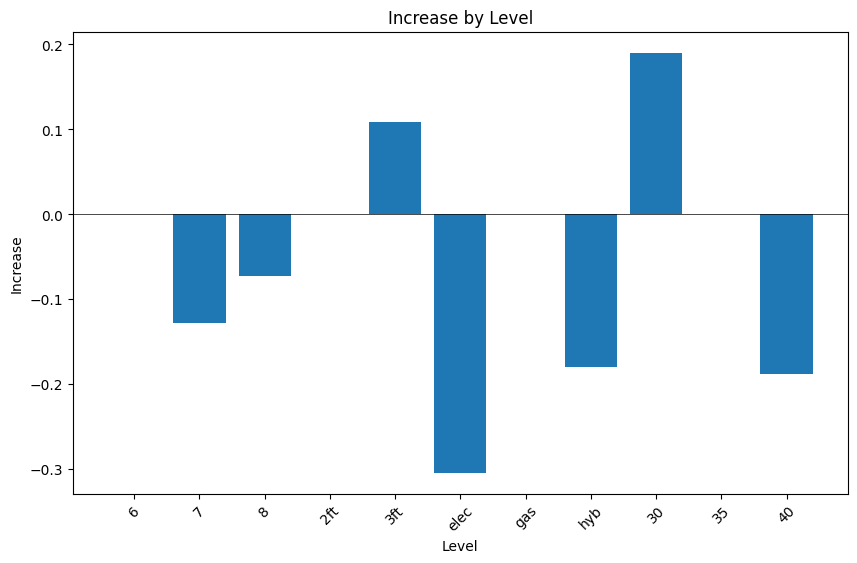

In [21]:
sensitivity_results['level'] = sensitivity_results['level'].astype(str) # converting to string for plotting
plt.figure(figsize=(10, 6))
plt.bar(sensitivity_results['level'], sensitivity_results['increase'])
plt.xlabel('Level')
plt.ylabel('Increase')
plt.title('Increase by Level')
plt.axhline(y=0, color='black', linewidth=0.5)
plt.xticks(rotation=45)
plt.show()


